Accuracy of Naive Bayes: 0.9668
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115


Accuracy of Logistic Regression: 0.9525
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.97      0.67      0.79       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115


Accuracy of Support Vector Machine: 0.9794
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.98      1.00     

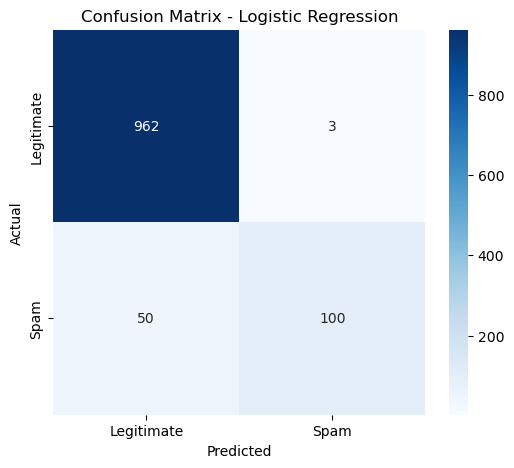

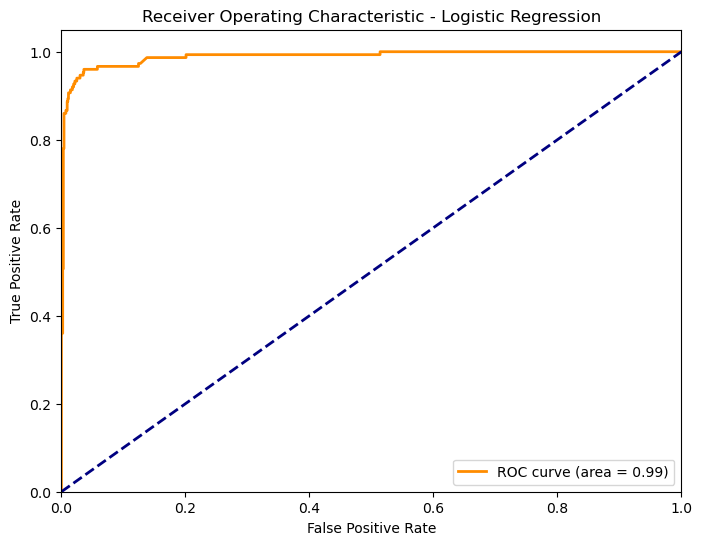

C:\Users\tripa\AppData\Local\Temp\ipykernel_13364\4006311560.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in top_features], y=[x[0] for x in top_features], palette="viridis")


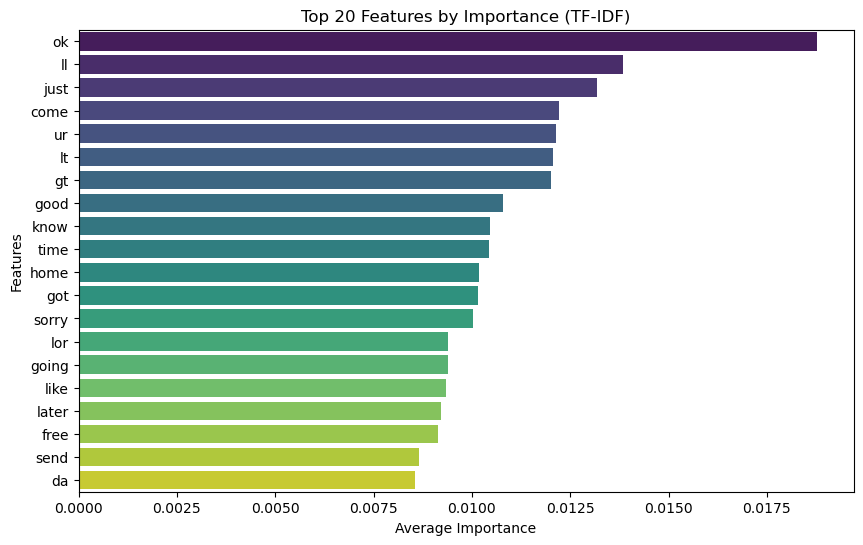

Model and vectorizer saved. Graphs generated and saved as images.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib

data = pd.read_csv("spam.csv", encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

X = data['message']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(kernel='linear', probability=True)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name}: {acc:.4f}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}\n")
    results[model_name] = {"model": model, "accuracy": acc, "y_pred": y_pred}

best_model = results["Logistic Regression"]["model"]
joblib.dump(best_model, "spam_sms_logistic_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

conf_matrix = confusion_matrix(y_test, results["Logistic Regression"]["y_pred"])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate", "Spam"], yticklabels=["Legitimate", "Spam"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix.png")
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test_tfidf)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - Logistic Regression")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

feature_importances = np.mean(X_train_tfidf.toarray(), axis=0)
features = vectorizer.get_feature_names_out()
top_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=[x[1] for x in top_features], y=[x[0] for x in top_features], palette="viridis")
plt.title("Top 20 Features by Importance (TF-IDF)")
plt.xlabel("Average Importance")
plt.ylabel("Features")
plt.savefig("top_features.png")
plt.show()

print("Model and vectorizer saved. Graphs generated and saved as images.")
